In [ ]:
# TS=("cloud computing" AND ("event-driven architecture" OR "EDA") AND ("complex event processing" OR "CEP"))
# 3 registros

pip install pandas openpyxl matplotlib seaborn fuzzywuzzy networkx scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import matplotlib.image as mpimg
import geopandas as gpd
from fuzzywuzzy import process
import networkx as nx
from collections import Counter 
import numpy as np 
from IPython.display import SVG, display

/Users/f.areias/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [16]:
df = pd.read_excel('datasets/atividade02/Q2.xlsx', engine='openpyxl')
df.shape[0]

3

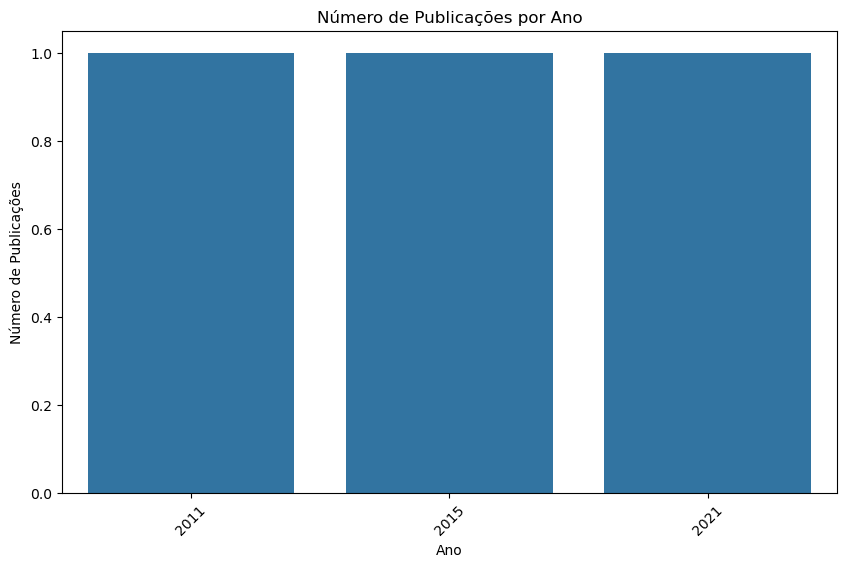

In [4]:
publicacoes_por_ano = df['Publication Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=publicacoes_por_ano.index, y=publicacoes_por_ano.values)
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.xticks(rotation=45)
plt.show()

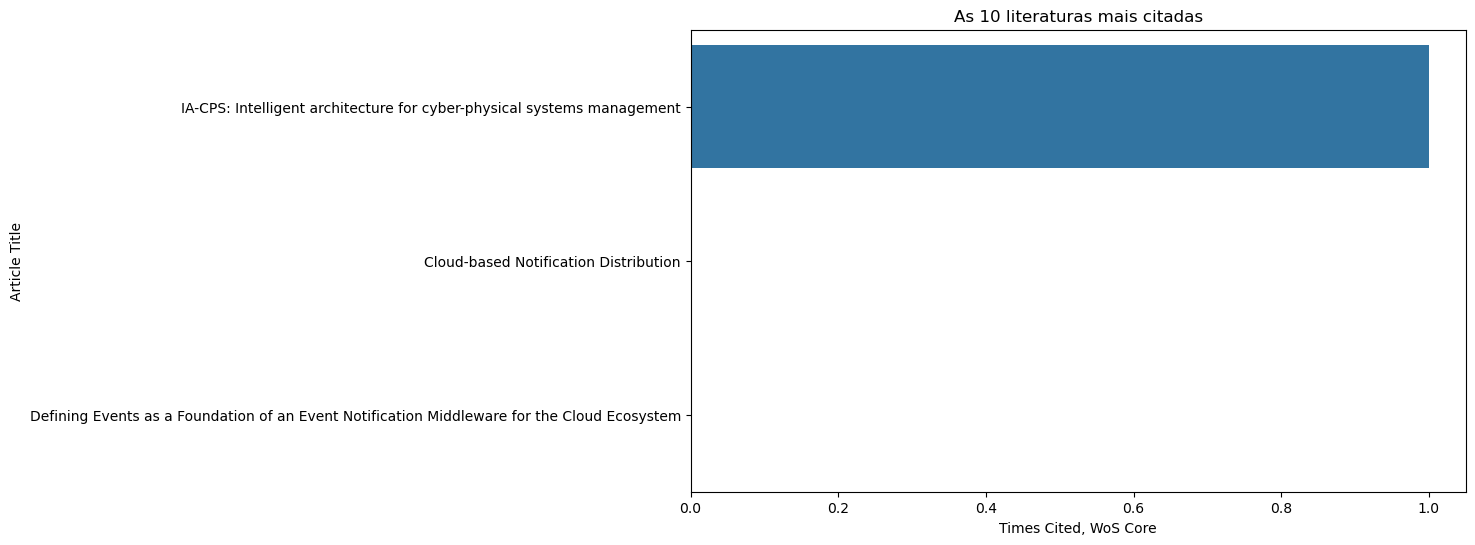

In [6]:
# 1. As 10 literaturas mais citadas

literature_data = df[['Article Title', 'Times Cited, WoS Core']].sort_values('Times Cited, WoS Core', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Times Cited, WoS Core', y='Article Title', data=literature_data)
plt.title('As 10 literaturas mais citadas')
plt.show() 

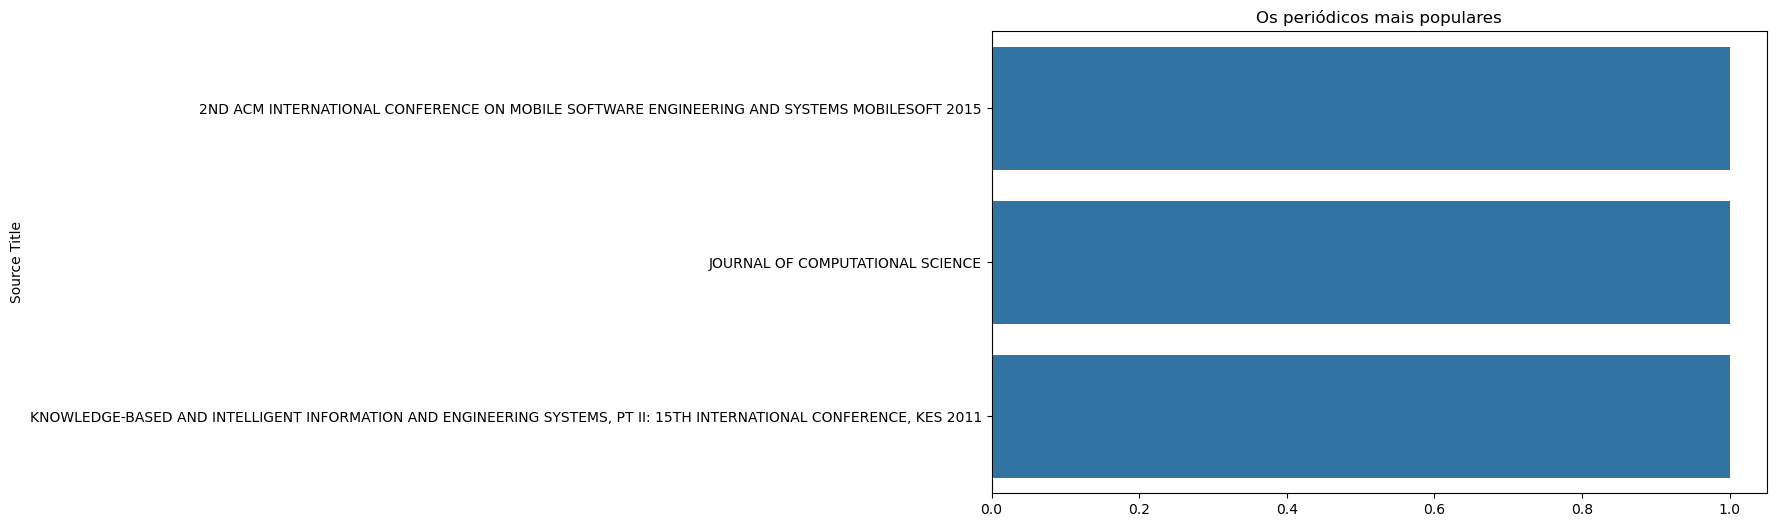

In [7]:
# 2. Os periódicos mais populares

journal_data = df['Source Title'].value_counts().head(7)
plt.figure(figsize=(10,6))
sns.barplot(x=journal_data.values, y=journal_data.index)
plt.title('Os periódicos mais populares')
plt.show() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                Author  Publication Count
0           Koschel, A                  2
1           Astrova, I                  1
2           Kleiner, C                  1
3              Nitz, S                  1
4            Gómez, HD                  1
5  Garcia-Rodriguez, J                  1
6      Azorin-Lopez, J                  1
7             Tomás, D                  1
8     Fuster-Guillo, A                  1
9         Mora-Mora, H                  1


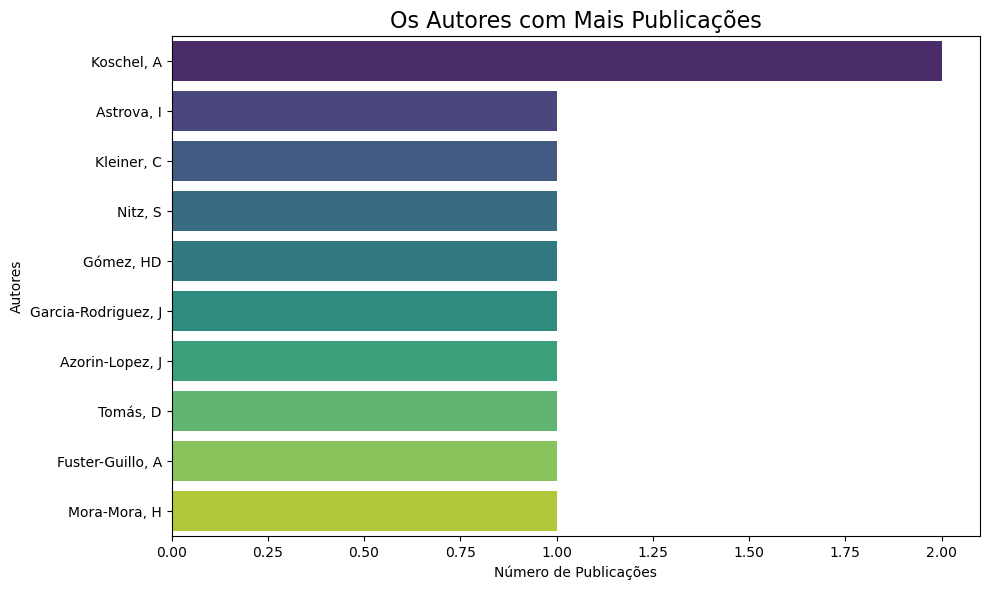

In [8]:
df_temp = df.copy()

df_temp['Authors'] = df_temp['Authors'].str.split('; ')
df_temp = df_temp.explode('Authors')

df_unique = df_temp.drop_duplicates(subset=['Authors', 'Article Title'])

author_data = df_unique['Authors'].value_counts().head(10)

author_df = author_data.reset_index()
author_df.columns = ['Author', 'Publication Count']

print(author_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Publication Count', y='Author', data=author_df, hue='Author', palette='viridis', dodge=False)
plt.title('Os Autores com Mais Publicações', fontsize=16)
plt.xlabel('Número de Publicações')
plt.ylabel('Autores')
plt.legend().set_visible(False) 
plt.tight_layout()
plt.show()

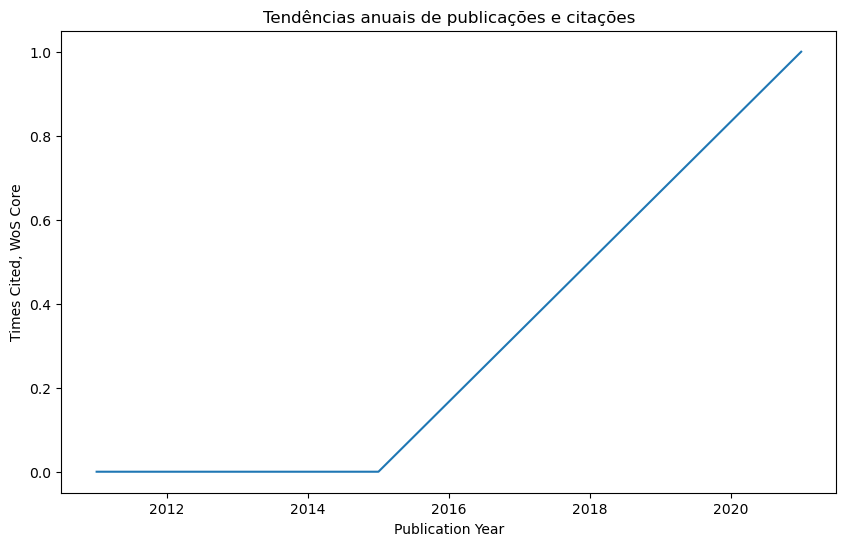

In [9]:
# 4. Tendências anuais de publicações e citações
yearly_trend = df.groupby('Publication Year')['Times Cited, WoS Core'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='Publication Year', y='Times Cited, WoS Core', data=yearly_trend)
plt.title('Tendências anuais de publicações e citações')
plt.show() 

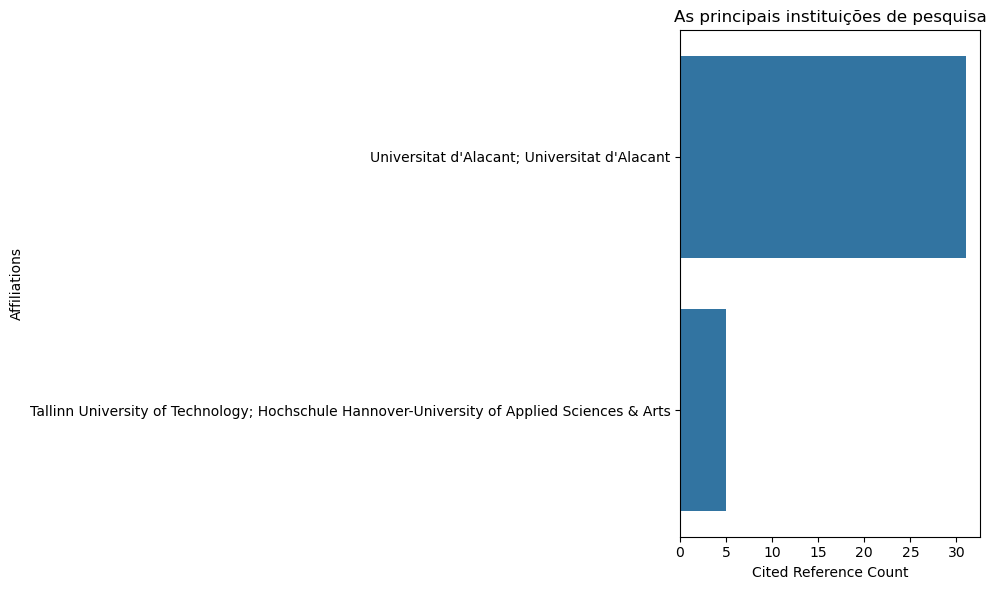

In [10]:
# Principais instituicoes de pesquisa
top_institutions = df[['Affiliations', 'Cited Reference Count']].groupby('Affiliations').sum().nlargest(10, 'Cited Reference Count').reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Cited Reference Count', y='Affiliations', data=top_institutions)
plt.title('As principais instituições de pesquisa')
plt.xlabel('Cited Reference Count')
plt.ylabel('Affiliations')
plt.tight_layout()
plt.show()


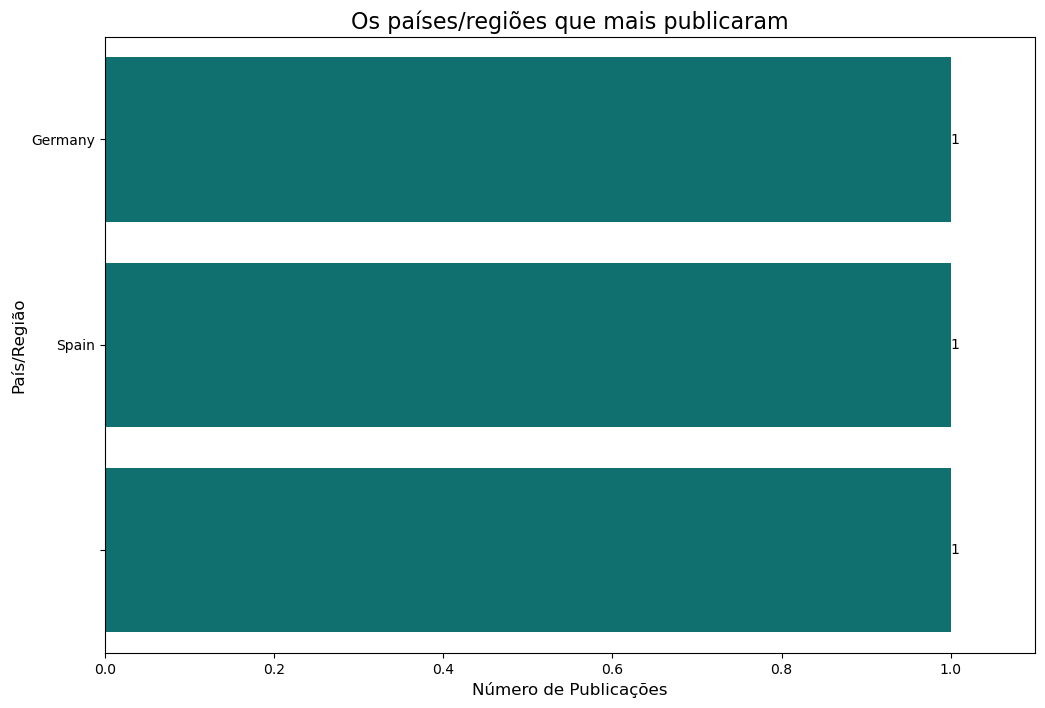

In [11]:
def clean_country_name(name):
    name = name.strip()
    if 'USA' in name:
        return 'United States'
    if 'R China' in name:
        return 'People\'s Republic of China'
    return name

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip())
countries_data = countries_data.map(clean_country_name).value_counts().head(10)

plt.figure(figsize=(12, 8))

sns.barplot(x=countries_data.values, y=countries_data.index, color='teal')  

plt.title('Os países/regiões que mais publicaram', fontsize=16)
plt.xlabel('Número de Publicações', fontsize=12)
plt.ylabel('País/Região', fontsize=12)

for index, value in enumerate(countries_data.values):
    plt.text(value, index, f'{value}', va='center')

plt.xlim(0, countries_data.max() * 1.1) 
plt.show()


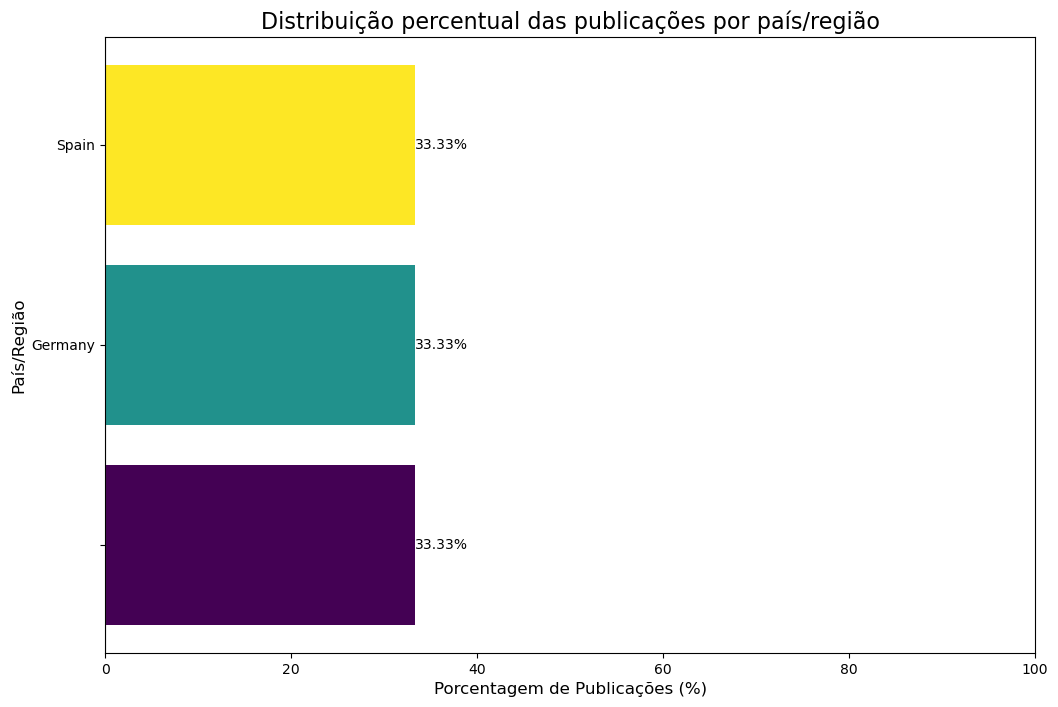

In [12]:
countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts()

countries_data.index = countries_data.index.map(clean_country_name)

countries_data = countries_data.groupby(countries_data.index).sum()

total_publications = countries_data.sum()
countries_percentage = (countries_data / total_publications) * 100

countries_percentage = countries_percentage[countries_percentage > 0.5]

countries_percentage = countries_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(countries_percentage))) 
bars = plt.barh(countries_percentage.index, countries_percentage.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

plt.title('Distribuição percentual das publicações por país/região', fontsize=16)
plt.xlabel('Porcentagem de Publicações (%)', fontsize=12)
plt.ylabel('País/Região', fontsize=12)
plt.xlim(0, 100)  
plt.axvline(0, color='grey', linewidth=0.8) 
plt.show()


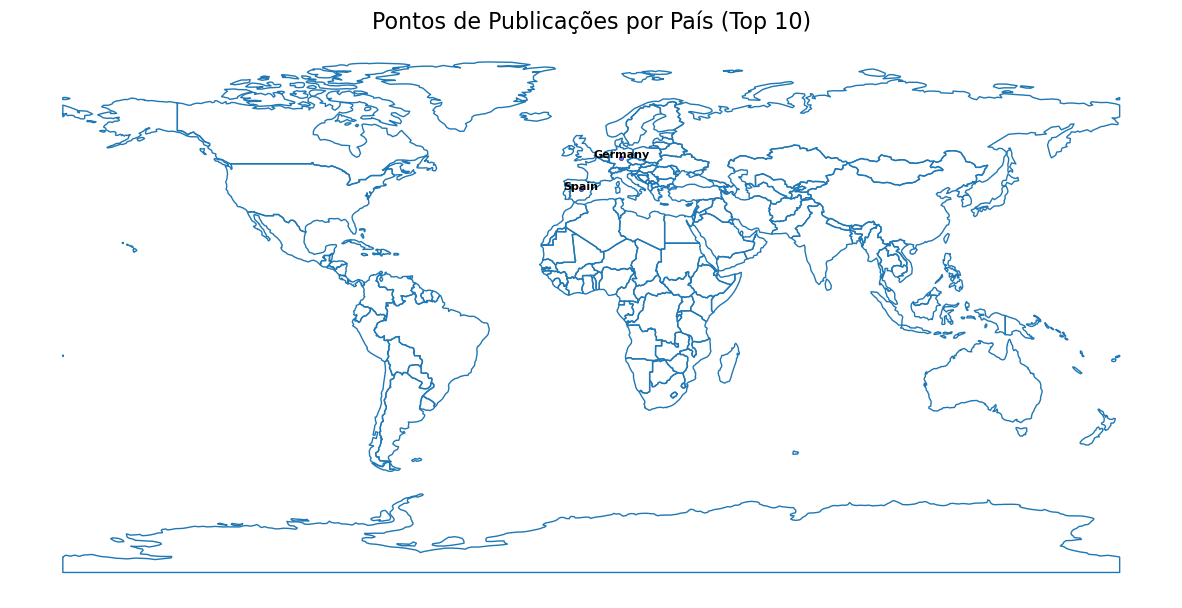

In [13]:

 

world = gpd.read_file('datasets/map/ne_110m_admin_0_countries.shp')

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip())
countries_data = countries_data.map(clean_country_name).value_counts()

countries_df = pd.DataFrame(countries_data).reset_index()
countries_df.columns = ['Country', 'Publication Count']

top_countries_df = countries_df.nlargest(10, 'Publication Count')

world['ADMIN'] = world['ADMIN'].str.strip().str.title()

def get_best_match(country_name, choices):
    if not country_name:  
        return None
    match, score = process.extractOne(country_name, choices)
    return match if score >= 80 else None  

geo_countries = world['ADMIN'].unique()

top_countries_df['Country'] = top_countries_df['Country'].apply(lambda x: get_best_match(x, geo_countries))

top_countries_df = top_countries_df.dropna(subset=['Country'])

merged = world.merge(top_countries_df, how="left", left_on="ADMIN", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, linewidth=1)

for idx, row in merged.iterrows():
    if row['Publication Count'] > 0:
        ax.scatter(*row.geometry.centroid.coords[0], 
                   s=row['Publication Count'] * 10, 
                   alpha=0.6, color='blue', edgecolor='k', linewidth=0.5)
        ax.annotate(text=row['Country'], 
                    xy=row.geometry.centroid.coords[0], 
                    ha='center', fontsize=8, color='black', weight='bold')

plt.title('Pontos de Publicações por País (Top 10)', fontsize=16)
plt.axis('off') 
plt.show()


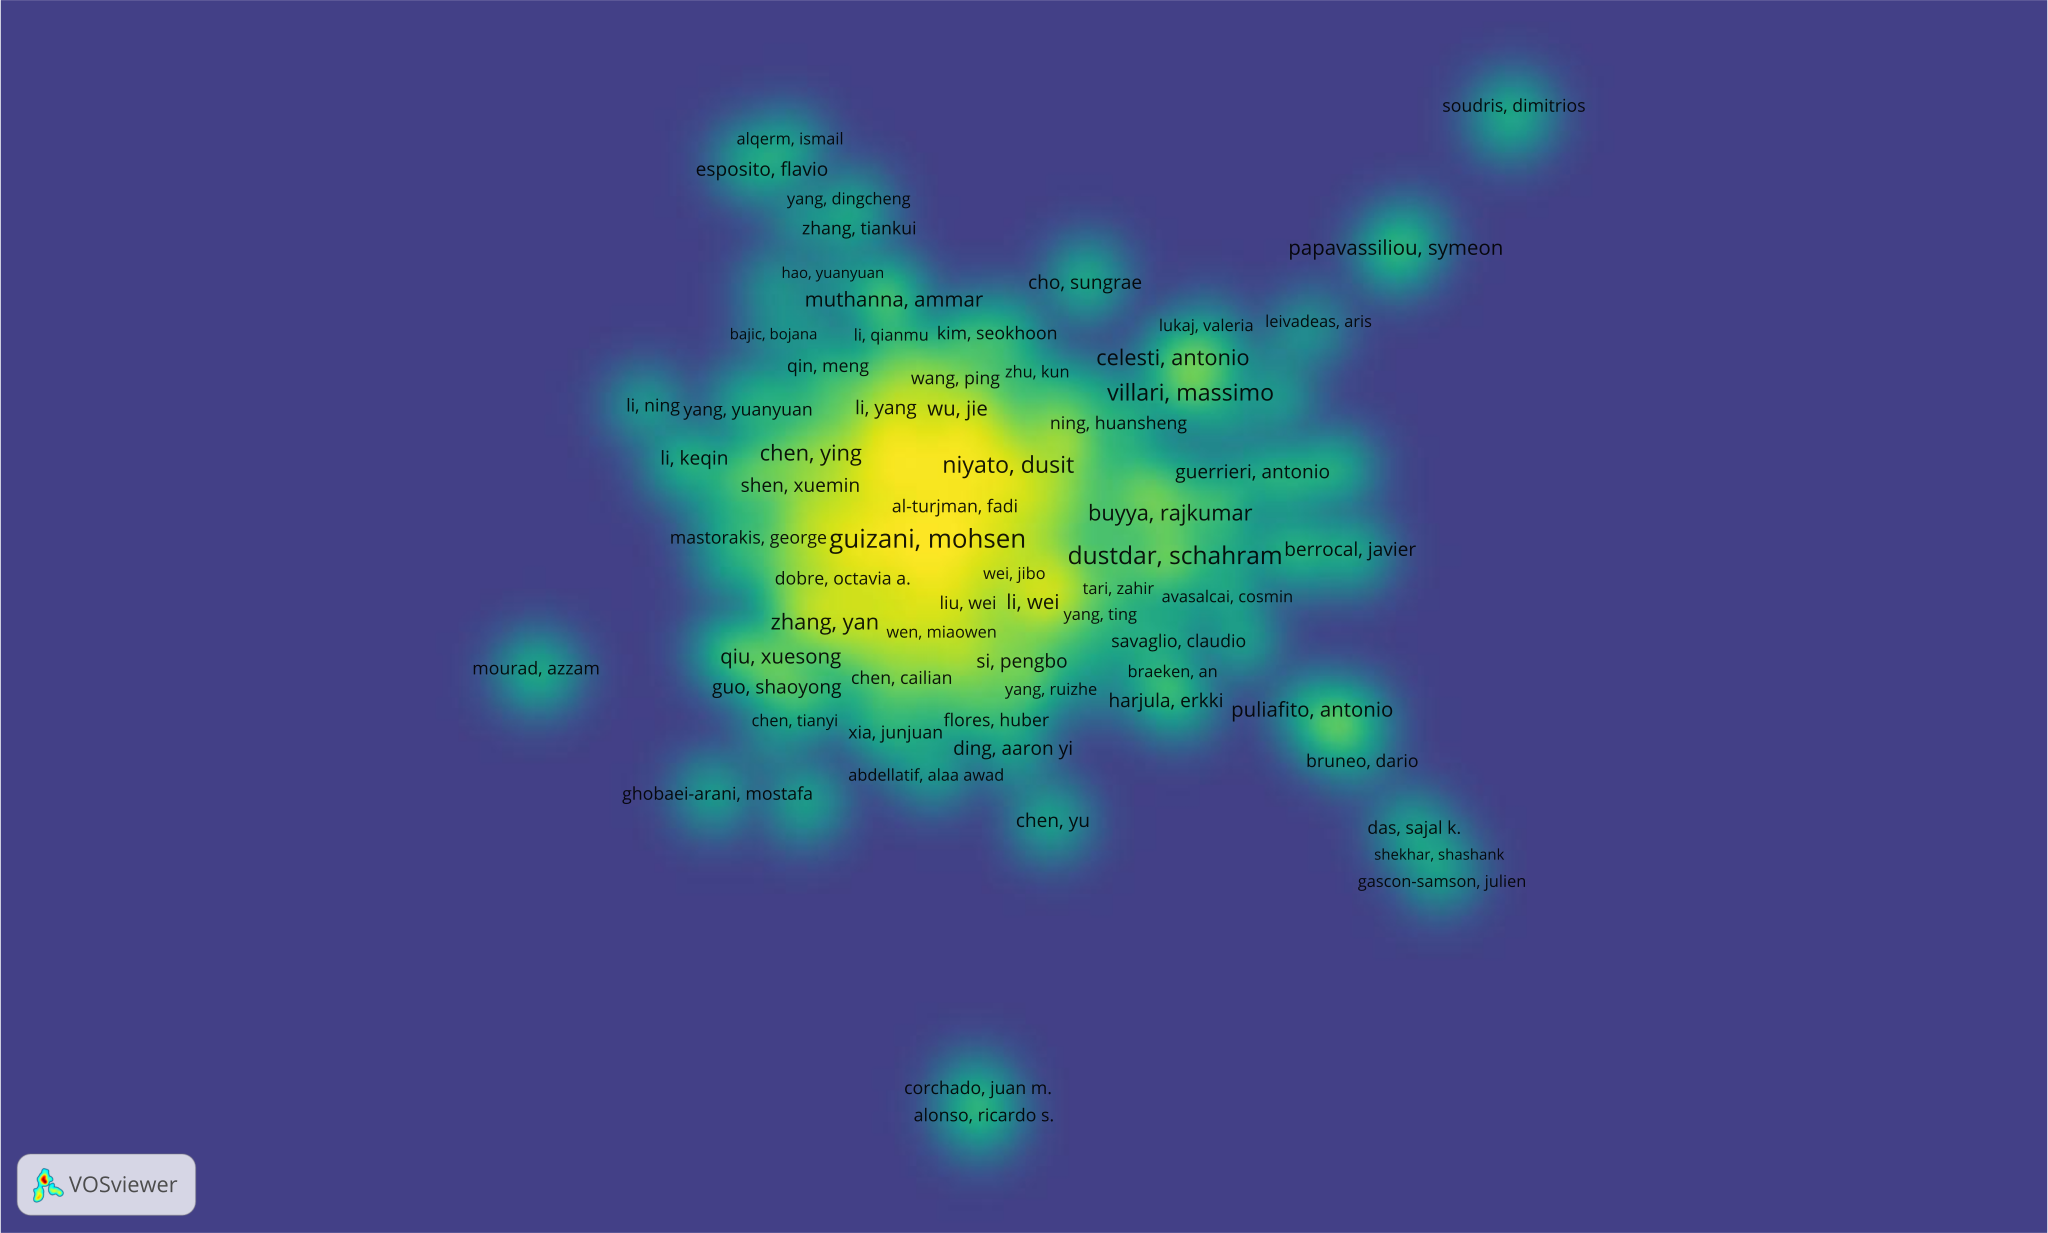

In [19]:
#Mapa de calor de co-authors
file_path = "imgs/co-author-density.svg"
display(SVG(filename=file_path))

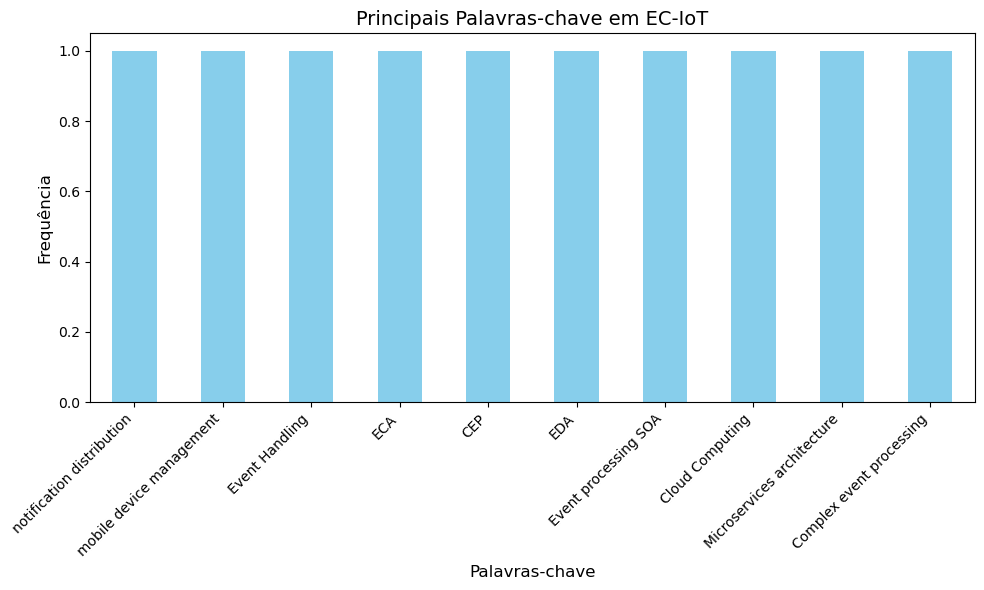

In [14]:
df_temp = df['Author Keywords'].dropna()

df_temp = df_temp.str.split(';')

df_keywords = df_temp.explode()

df_keywords = df_keywords.str.strip()

keyword_counts = df_keywords.value_counts()

top_keywords = keyword_counts.index.tolist()[:10] 

plt.figure(figsize=(10, 6))
keyword_counts.head(10).plot(kind='bar', color='skyblue')

plt.title('Principais Palavras-chave em EC-IoT', fontsize=14)
plt.xlabel('Palavras-chave', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
